# Pre-Emphasis and Pre-Emphasis+Windowing Notebook

In [3]:
# Import Libraries
import pandas as pd
import numpy as np 
import glob
import os
from os.path import isfile, join
import soundfile as sf 
import sys
import librosa 
import librosa.display
import seaborn as sbn
import matplotlib.pyplot as plt 
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from IPython.display import Audio
import scipy.io.wavfile
from scipy.fftpack import dct
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from os import listdir
from os.path import isfile, join

In [ ]:
# Pre-Emphasis

# Set the home and destination directories
home = "C:/Users/Lenovo/Documents/3rd Year Project/Dataset/Combined_Baseline_Shortened_Cropped/"
destination = "C:/Users/Lenovo/Documents/3rd Year Project/Dataset/Combined_Pre-Emphasis_Shortened_Cropped/"

# Set the pre-emphasis coefficient
pre_emphasis_coeff = 0.97

# Loop through each file in the home directory
for filename in os.listdir(home):
    if filename.endswith(".wav"):
        # Load the audio file and sample rate using Librosa
        filepath = os.path.join(home, filename)
        signal, sr = librosa.load(filepath, sr=None)
        
        # Apply pre-emphasis to the signal
        emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis_coeff * signal[:-1])
        
        # Save the pre-emphasized signal to the destination directory
        output_filename = os.path.join(destination, filename)
        sf.write(output_filename, emphasized_signal, sr)


In [ ]:
from scipy.signal import hamming

# Set the home and destination directories
home = "C:/Users/Lenovo/Documents/3rd Year Project/Dataset/Combined_Pre-Emphasis_Shortened_Cropped/"
destination = "C:/Users/Lenovo/Documents/3rd Year Project/Dataset/Combined_EmphasisHamming_Shortened_Cropped/"

# Get list of all files in home directory
homeList = os.listdir(home)

# Loop through all files in home directory
for dir in homeList:
    # Load audio file
    signal, sr = librosa.load(home + dir)

    # Calculate window length and hop length
    window_length = int(sr * 0.025) # 25ms window length
    hop_length = int(sr * 0.010) # 10ms hop length
    
    # Create Hamming window
    hamming_window = hamming(window_length)
    
    # Pad signal to ensure it can be split into frames without overlap
    n_frames = int(np.ceil(len(signal) / hop_length))
    signal_length = n_frames * hop_length
    padding = signal_length - len(signal)
    signal_padded = np.pad(signal, (0, padding), 'constant', constant_values=0)
    
    # Apply Hamming window to signal using overlapping frames
    frames = librosa.util.frame(signal_padded, frame_length=window_length, hop_length=hop_length)
    windowed_frames = frames * hamming_window[:, np.newaxis]
    signal_hamming = np.zeros(len(signal_padded))
    for i in range(frames.shape[1]):
        start = i * hop_length
        end = start + window_length
        signal_hamming[start:end] += windowed_frames[:, i]
    signal_hamming = signal_hamming[:len(signal)]
    
    # Save the modified audio file to destination directory
    savePath = destination + dir
    sf.write(savePath, signal_hamming, sr)

In [4]:
# MFCC Feature Extraction
data = []
label = []
Path = "C:/Users/Lenovo/Documents/3rd Year Project/Dataset/Combined_Pre-Emphasis_Shortened_Cropped/"
#Path = "C:/Users/Lenovo/Documents/3rd Year Project/Dataset/Combined_EmphasisHamming_Shortened_Cropped/"
files = [f for f in listdir(Path) if isfile(join(Path, f))]
for x in files:
    filePath = Path + x
    label.append(x[0])
    signal, sr = librosa.load(filePath, sr=None)
    #mfcc = librosa.feature.mfcc(signal, n_fft=2048, hop_length = 256, n_mfcc = 20) 
    mfcc = librosa.feature.mfcc(signal, n_fft=2048, hop_length = 256, n_mfcc = 18) 
    #mfcc_1d = np.ravel(mfcc)
    data.append(mfcc)

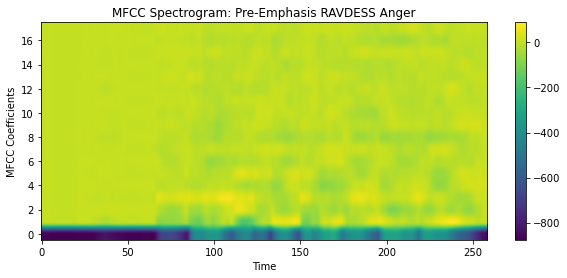

In [7]:
# Display MFCC Spectrogram

# Display Anger MFCC on a spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(data[124], origin='lower', aspect='auto')
plt.colorbar()
plt.title('MFCC Spectrogram: Pre-Emphasis RAVDESS Anger')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')
plt.show()

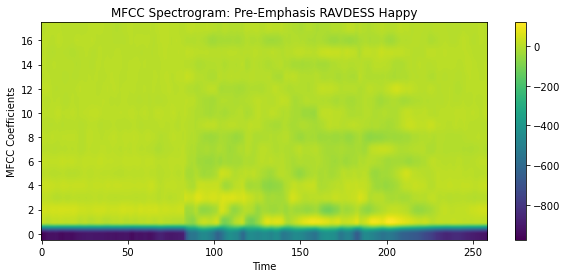

In [6]:
# Display MFCC Spectrogram

# Display Anger MFCC on a spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(data[372], origin='lower', aspect='auto')
plt.colorbar()
plt.title('MFCC Spectrogram: Pre-Emphasis RAVDESS Happy')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')
plt.show()

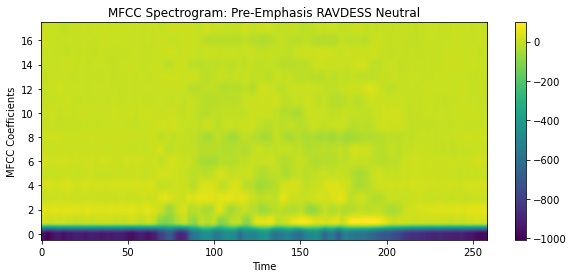

In [8]:
# Display MFCC Spectrogram

# Display Anger MFCC on a spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(data[621], origin='lower', aspect='auto')
plt.colorbar()
plt.title('MFCC Spectrogram: Pre-Emphasis RAVDESS Neutral')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')
plt.show()

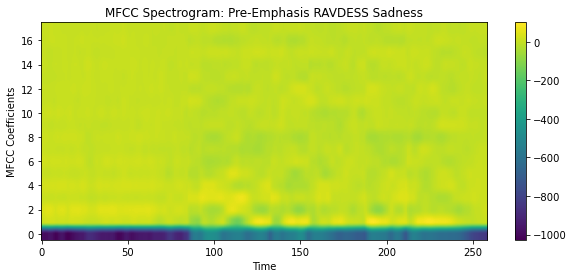

In [9]:
# Display MFCC Spectrogram

# Display Anger MFCC on a spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(data[868], origin='lower', aspect='auto')
plt.colorbar()
plt.title('MFCC Spectrogram: Pre-Emphasis RAVDESS Sadness')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')
plt.show()

In [10]:
#Check MFCC data shape
data = np.array(data)
data.shape

(992, 18, 259)

In [11]:
# Change dimensions
X = np.expand_dims(data, axis=3)
X.shape

(992, 18, 259, 1)

In [12]:
# Label the emotions as numbers
label_new = []
for i in range(len(label)):
    if label[i] == 'n': #Neutral
        x=3
    elif label[i] == 'h': #Happy
        x=0
    elif label[i] == 's': #Sadness
        x=1
    elif label[i] == 'a': #Angry
        x = 2
    label_new.append(x)

#print(label_new)

In [13]:
# Split data for training and testing
x_train, x_test, y_train, y_test = train_test_split(X, label_new, test_size = 0.2)

In [14]:
# Convert data to np arrays
X_train = np.array(x_train)
X_test = np.array(x_test)
Y_train = np.array(y_train)
Y_test = np.array(y_test)
print(X_train.shape)

(793, 18, 259, 1)


In [15]:
# Build CNN Classifier
model = Sequential()
from keras.layers import BatchNormalization
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(18, 259, 1)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units=4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 259, 64)       640       
                                                                 
 batch_normalization (BatchN  (None, 18, 259, 64)      256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 259, 64)       36928     
                                                                 
 batch_normalization_1 (Batc  (None, 18, 259, 64)      256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 129, 64)       0         
 )                                                               
                                                        

In [16]:
# Train and Test Model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=32 , epochs= 20 , verbose=1, validation_data=(X_test, Y_test))
# Pre-emphasis gives val_accuracy: 70.35% 20 epochs val_loss 1.3230
# Pre-emphasis + Windowing gives val accuracy: 75.28%, val loss: 0.994

Epoch 1/20
25/25 [==============================] - 174s 6s/step - loss: 1.6187 - accuracy: 0.4741 - val_loss: 90.7577 - val_accuracy: 0.2814
Epoch 2/20
25/25 [==============================] - 112s 4s/step - loss: 0.8141 - accuracy: 0.6999 - val_loss: 32.3864 - val_accuracy: 0.1508
Epoch 3/20
25/25 [==============================] - 123s 5s/step - loss: 0.5787 - accuracy: 0.7919 - val_loss: 11.5696 - val_accuracy: 0.2010
Epoch 4/20
25/25 [==============================] - 120s 5s/step - loss: 0.4235 - accuracy: 0.8348 - val_loss: 6.4032 - val_accuracy: 0.2211
Epoch 5/20
25/25 [==============================] - 140s 6s/step - loss: 0.2978 - accuracy: 0.8916 - val_loss: 3.0509 - val_accuracy: 0.3015
Epoch 6/20
25/25 [==============================] - 125s 5s/step - loss: 0.1575 - accuracy: 0.9357 - val_loss: 2.1319 - val_accuracy: 0.4171
Epoch 7/20
25/25 [==============================] - 145s 6s/step - loss: 0.1577 - accuracy: 0.9433 - val_loss: 1.9233 - val_accuracy: 0.5176
Epoch 8/20

In [57]:
# Calculate precision and recall
# Get the predicted probabilities for the validation set
y_pred_proba = model.predict(X_test)

# Convert the predicted probabilities to class labels
y_pred = np.argmax(y_pred_proba, axis=1)

# Compute precision and recall using scikit-learn metrics
from sklearn.metrics import precision_score, recall_score
precision = precision_score(Y_test, y_pred, average='weighted')
recall = recall_score(Y_test, y_pred, average='weighted')

print('Precision:', precision)
print('Recall:', recall)

# Pre-Emphasis
# Pre-Emphasis + Windowing: Precision: 77.97% Recall: 75.37%

7/7 [==============================] - 32s 2s/step
Precision: 0.7797808378580502
Recall: 0.7537688442211056


In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,Y_test)[1]*100 , "%")

epochs = [i for i in range(24)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(24,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss: Hamming Window')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy: Pre-Emphasis')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

7/7 [==============================] - 13s 2s/step


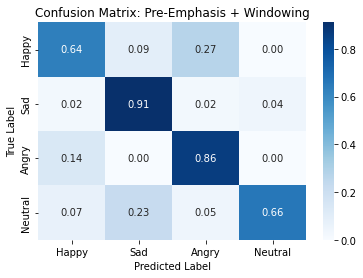

In [58]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# make predictions on the test set
y_pred = model.predict(x_test)

# define y_true as the one-hot encoded version of the test labels
y_true = np.zeros((len(y_test), 4)) # 4 is the number of emotions being classified
y_true[np.arange(len(y_test)), y_test] = 1

# convert y_pred from probabilities to class labels
predicted_labels = np.argmax(y_pred, axis=1)

# define y_pred as the one-hot encoded version of the predicted labels
y_pred = np.zeros((len(predicted_labels), 4)) # 4 is the number of emotions being classified
y_pred[np.arange(len(predicted_labels)), predicted_labels] = 1

# compute confusion matrix
cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1), normalize='true')
labels = ['Happy', 'Sad', 'Angry', 'Neutral'] # replace with your own emotion labels

# plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)

# add axis labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Pre-Emphasis + Windowing')

# show the plot
plt.show()


In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# make predictions on the test set
y_pred = model.predict(x_test)

# define y_true as the one-hot encoded version of the test labels
y_true = np.zeros((len(y_test), 4)) # 4 is the number of emotions being classified
y_true[np.arange(len(y_test)), y_test] = 1

# convert y_pred from probabilities to class labels
predicted_labels = np.argmax(y_pred, axis=1)

# define y_pred as the one-hot encoded version of the predicted labels
y_pred = np.zeros((len(predicted_labels), 4)) # 4 is the number of emotions being classified
y_pred[np.arange(len(predicted_labels)), predicted_labels] = 1

# compute confusion matrix
cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1), normalize='true')
labels = ['Happy', 'Sad', 'Angry', 'Neutral'] # replace with your own emotion labels

# plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)

# add axis labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Pre-Emphasis')

# show the plot
plt.show()
